In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

In [18]:
"""
Create Your Own Plasma PIC Simulation (With Python)
Philip Mocz (2020) Princeton Univeristy, @PMocz
Simulate the 1D Two-Stream Instability
Code calculates the motions of electron under the Poisson-Maxwell equation
using the Particle-In-Cell (PIC) method
"""


def getAcc( pos, Nx, boxsize, n0, Gmtx, Lmtx ):
    """
    Calculate the acceleration on each particle due to electric field
    pos      is an Nx1 matrix of particle positions
    Nx       is the number of mesh cells
    boxsize  is the domain [0,boxsize]
    n0       is the electron number density
    Gmtx     is an Nx x Nx matrix for calculating the gradient on the grid
    Lmtx     is an Nx x Nx matrix for calculating the laplacian on the grid
    a        is an Nx1 matrix of accelerations
    """
    # Calculate Electron Number Density on the Mesh by
    # placing particles into the 2 nearest bins (j & j+1, with proper weights)
    # and normalizing
    N          = pos.shape[0]
    dx         = boxsize / Nx
    j          = np.floor(pos/dx).astype(int)
    jp1        = j+1
    weight_j   = ( jp1*dx - pos  )/dx
    weight_jp1 = ( pos    - j*dx )/dx
    jp1        = np.mod(jp1, Nx)   # periodic BC
    n  = np.bincount(j[:,0],   weights=weight_j[:,0],   minlength=Nx);
    n += np.bincount(jp1[:,0], weights=weight_jp1[:,0], minlength=Nx);
    n *= n0 * boxsize / N / dx

    # Solve Poisson's Equation: laplacian(phi) = n-n0
    phi_grid = spsolve(Lmtx, n-n0, permc_spec="MMD_AT_PLUS_A")

    # Apply Derivative to get the Electric field
    E_grid = - Gmtx @ phi_grid

    # Interpolate grid value onto particle locations
    E = weight_j * E_grid[j] + weight_jp1 * E_grid[jp1]

    a = -E

    return a


In [21]:
def main():
    """ Plasma PIC simulation """

    # Simulation parameters
    N         = 40000   # Number of particles
    Nx        = 400     # Number of mesh cells
    t         = 0       # current time of the simulation
    tEnd      = 50      # time at which simulation ends
    dt        = 1       # timestep
    boxsize   = 50      # periodic domain [0,boxsize]
    n0        = 1       # electron number density
    vb        = 3       # beam velocity
    vth       = 1       # beam width
    A         = 0.1     # perturbation
    plotRealTime = False # switch on for plotting as the simulation goes along

    # Generate Initial Conditions
    np.random.seed(42)            # set the random number generator seed
    # construct 2 opposite-moving Guassian beams
    pos  = np.random.rand(N,1) * boxsize
    vel  = vth * np.random.randn(N,1) + vb
    Nh = int(N/2)
    vel[Nh:] *= -1
    # add perturbation
    vel *= (1 + A*np.sin(2*np.pi*pos/boxsize))

    # Construct matrix G to computer Gradient  (1st derivative)
    dx = boxsize/Nx
    e = np.ones(Nx)
    diags = np.array([-1,1])
    vals  = np.vstack((-e,e))
    Gmtx = sp.spdiags(vals, diags, Nx, Nx);
    Gmtx = sp.lil_matrix(Gmtx)
    Gmtx[0,Nx-1] = -1
    Gmtx[Nx-1,0] = 1
    Gmtx /= (2*dx)
    Gmtx = sp.csr_matrix(Gmtx)

    # Construct matrix L to computer Laplacian (2nd derivative)
    diags = np.array([-1,0,1])
    vals  = np.vstack((e,-2*e,e))
    Lmtx = sp.spdiags(vals, diags, Nx, Nx);
    Lmtx = sp.lil_matrix(Lmtx)
    Lmtx[0,Nx-1] = 1
    Lmtx[Nx-1,0] = 1
    Lmtx /= dx**2
    Lmtx = sp.csr_matrix(Lmtx)

    # calculate initial gravitational accelerations
    acc = getAcc( pos, Nx, boxsize, n0, Gmtx, Lmtx )

    # number of timesteps
    Nt = int(np.ceil(tEnd/dt))

    # prep figure
    fig = plt.figure(figsize=(5,4), dpi=80)

    # Simulation Main Loop
    for i in range(Nt):
        # (1/2) kick
        vel += acc * dt/2.0

        # drift (and apply periodic boundary conditions)
        pos += vel * dt
        pos = np.mod(pos, boxsize)

        # update accelerations
        acc = getAcc( pos, Nx, boxsize, n0, Gmtx, Lmtx )

        # (1/2) kick
        vel += acc * dt/2.0

        # update time
        t += dt

        # plot in real time - color 1/2 particles blue, other half red
        if plotRealTime or (i == Nt-1):
            plt.cla()
            plt.scatter(pos[0:Nh],vel[0:Nh],s=.4,color='blue', alpha=0.5)
            plt.scatter(pos[Nh:], vel[Nh:], s=.4,color='red',  alpha=0.5)
            plt.axis([0,boxsize,-6,6])

            plt.pause(0.001)


    # Save figure
    plt.xlabel('x')
    plt.ylabel('v')
    plt.savefig('pic.png',dpi=240)
    plt.show()

    return 0


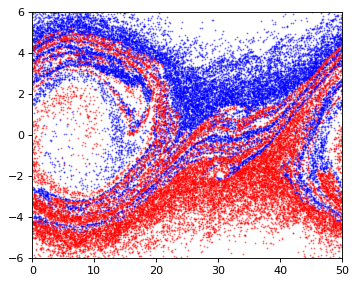

In [ ]:
main()